In [3]:
import torch
import torch.nn as nn

# Import the gym module
import gym
import numpy as np
import time 

In [4]:
# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')

In [5]:
def preprocess(img):
    # 저장할 때는 전처리를 거친 후 np.array 형태로 저장
    img = np.mean(img, axis=2).astype(np.uint8) # to gray, uint8 for low memory
    img = img[::2, ::2][17:97] # downsample(1/2) & to square
    img = np.expand_dims(img, 0) # (1, 80, 80)
    return img

In [6]:
s = env.reset()

s2, _, _, _ = env.step(0)

In [7]:
s = env.reset()
i = 0
done = False
while not done:
    a = env.action_space.sample()
    s2, _, done, _ = env.step(a)
    i += 1
i

138

In [8]:
from matplotlib import pyplot as plt
plt.imshow(s2)

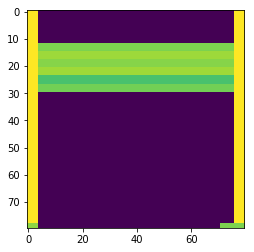

In [9]:
plt.imshow(preprocess(s2)[0])

In [10]:
from collections import deque
import random 

class ReplayMemory(object):
    def __init__(self, capacity):
        self.deque = deque(maxlen=capacity)
    
    def append(self, state, action, reward, next_state, done):
        self.deque.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.deque, batch_size)
    
    def __len__(self):
        return len(self.deque)

In [11]:
class HistoryTransformer(object):
    def __init__(self, n_history=4):
        self.n_history = n_history
        self.deque = deque(maxlen=n_history)
        self.env = gym.make('BreakoutDeterministic-v4')
        
        # 최초에는 처음 화면(env.reset) 0으로 채워둠
        padding_state = preprocess(self.env.reset())
        for _ in range(n_history):
            self.deque.append(padding_state)
    
    def preprocess(self, img):
        # 저장할 때는 전처리를 거친 후 np.array 형태로 저장
        img = np.mean(img, axis=2).astype(np.uint8) # to gray, uint8 for low memory
        img = img[::2, ::2][17:97] # downsample(1/2) & to square
        img = np.expand_dims(img, 0) # (1, 80, 80)
        return img
    
    def transform(self, s):
        # transform할 때 마다, 현재 state를 기록하고, 과거 state를 밀어내면서 저장함
        self.deque.append(self.preprocess(s))
        return np.stack([self.deque[i] for i in range(self.n_history)], axis=1)
    
    def __len__(self):
        return len(self.deque)

In [12]:
class DDQN(nn.Module):
    def __init__(self, in_dim, n_action):
        super(DDQN, self).__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, 32, (8, 8), stride=4), nn.ReLU(), # conv 1
            nn.Conv2d(32, 64, (4, 4), stride=2), nn.ReLU(), # conv 2
            nn.Conv2d(64, 64, (3, 3), stride=1), nn.ReLU() # conv 3
        )
        self.fc = nn.Sequential(
            nn.Linear(64*6*6, 512), nn.ReLU(), # hidden layer
            nn.Linear(512, n_action)
        )
        
    def to_tensor(self, img):
        img = torch.tensor(img, dtype=torch.float32, device=self.device).cuda(non_blocking=True) # to tensor
        img /= 255                                   # normalize into 0-1
        while img.dim() < 4 :                        # 4-dim
            img = img.unsqueeze(0)
        return img
        
    def forward(self, frames):
        frames = self.to_tensor(frames) 
        conved = self.conv(frames)
        conved = conved.view(conved.size(0), -1)
        output = self.fc(conved)
        return output

In [13]:
behaviorDDQN = DDQN(in_dim=4, n_action=4)
targetDDQN = DDQN(in_dim=4, n_action=4)

behaviorDDQN.to(behaviorDDQN.device) # model to cuda
targetDDQN.to(targetDDQN.device)     # model to cuda

DDQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [14]:
class Fitter():
    def __init__(self, behaviorDDQN, targetDDQN, n_history=4):
        self.behaviorDDQN = behaviorDDQN
        self.targetDDQN = targetDDQN
        self.out_dim = env.action_space.n
        self.env = gym.make('BreakoutDeterministic-v4')
        
        self.gamma = 0.99
        self.criterion = nn.MSELoss()
        self.optim = torch.optim.RMSprop(
            self.behaviorDDQN.parameters(), 
            lr=0.00025,
            eps=0.01,
            momentum=0.95
        )
            
        
    def train(self, train_batch):
        batch_size = len(train_batch)
        S = np.array([tup[0] for tup in train_batch]).squeeze(1) # states
        A = np.array([tup[1] for tup in train_batch]) # actions
        R = np.array([tup[2] for tup in train_batch]) # rewards
        S_next = np.array([tup[3] for tup in train_batch]).squeeze(1) # next_states 
        D = np.array([tup[4] for tup in train_batch]) # dones
        
        q_targets = self.targetDDQN(S)           # Q-values of current state with targetDDQN
        q_targets_next = self.targetDDQN(S_next) # Q-values of next state from targetDDQN
        next_behavior_network_actions = torch.argmax(self.behaviorDDQN(S_next), dim=1) # choose argmax actions from behaviorDDQN in S_next
        
        for i in range(batch_size):
            a, r, done = A[i], R[i], D[i]
            next_action = next_behavior_network_actions[i].item() # choose argmax actions from behaviorDDQN in S_next
            if done:
                q_targets[i, a] = r
            else:
                q_targets[i, a] = r + self.gamma*q_targets_next[i, next_action]
            
        # 예측치(pred)와 목표치(true)
        q_behavior = self.behaviorDDQN(S)
        
        self.optim.zero_grad()
        loss = self.criterion(q_targets, q_behavior)
        loss.backward()
        self.optim.step()
        return
    
    def update_target(self):
        self.targetDDQN.load_state_dict(self.behaviorDDQN.state_dict())
        return 
    
    def test(self):
        temp_hist_transformer = HistoryTransformer()
        initial_state = self.env.reset()
        n_step = 0
        r_sum = 0
        done=False
        
        while not done:
            # 게임의 맨 처음에는 움직여야 게임이 시작됨
            if n_step == 0:
                s, _, _, _ = self.env.step(1)  
                n_step += 1
                continue
            
            # 게임이 시작된 후, 공을 놓치면, life가 깍이고 다시 초기화면으로 돌아옴 
            # 이 경우 1,2,3 중 임의의 액션을 실행
            if s.all() == initial_state.all():
                a = random.choice([1, 2, 3])
            else:
                s_trans = temp_hist_transformer.transform(s)
                a = torch.argmax(self.behaviorDDQN(s_trans)).item()
            
            s, r, done, _ = self.env.step(a)
            n_step += 1
            r_sum += r
            
        print('Total Step: %s \t Total Score: %s'%(n_step, r_sum))
        return r_sum

In [15]:
fitter = Fitter(behaviorDDQN, targetDDQN)

In [45]:
def play_game(state_dict, replay_memory, n_frame, queue):
    return_ls = []
    net = DDQN(in_dim=4, n_action=4)
    net.to(net.device)
    net.load_state_dict(state_dict)

    for i in range(10):
        
        hist_transformer = HistoryTransformer() # history recorder (past 4 state)
        s = env.reset()
        s = hist_transformer.transform(s)

        e = epsilon_decay(i)
        done = False
        n_step = 0

        while not done:
            n_frame += 1
            n_step += 1

            # 초기 화면에서도 역시 일단 움직여야 게임이 시작됨
            if n_step == 1:
                a = random.choice([1, 2, 3])
            else:
                # Choose an action by e-greedy
                q_pred = net(s)

                if np.random.rand(1) < e :
                    a = env.action_space.sample()
                else:
                    a = torch.argmax(q_pred).item()

            # action 실행 후, replay_memory에 기록
            s_next, r, done, _ = env.step(a)
            if done:  
                r = -10

            # s_next를 변형 후 저장
            s_next = hist_transformer.transform(s_next)
            replay_memory.append(s, a , r, s_next, done)
            return_ls.append([s, a, r, s_next, done])
            s = s_next
            
    queue.put(return_ls)
    return

In [46]:
def epsilon_decay(n_frame):
    return np.max([1 - 9.0*1e-07*n_frame, 0.1])    

In [47]:
# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')

n_frame = 0
n_episode = 0
batch_size = 32

max_memory = 1000000
replay_memory = ReplayMemory(max_memory)

min_replay = 50000 # 50,000 in the paper
reward_ls = []

In [49]:
play_game(behaviorDDQN.state_dict(), replay_memory, n_frame, queue)

In [50]:
len(replay_memory)

1765

In [51]:
a = queue.get()

In [54]:
import torch.multiprocessing as mp

In [55]:
queue = mp.Queue()

In [56]:
torch.cuda.manual_seed(1234)

In [57]:
torch.multiprocessing.set_start_method("spawn")

RuntimeError: context has already been set

In [58]:
play_proc = mp.Process(target=play_game, args=(fitter.behaviorDDQN, replay_memory, n_frame, queue))

In [ ]:
torch.nn.Hu

In [59]:
play_proc.start()

KeyboardInterrupt: 

In [ ]:
queue.get()

In [ ]:
len(replay_memory)

In [46]:
def grow_batch_size(current_memory):
    # grow batch size from 32 to 128 as respect to memory size
    memory_ratio = current_memory / max_memory
    new_batch_size = int(32 + 96*memory_ratio)
    return new_batch_size

In [ ]:
while n_frame < 15000000 :
    n_episode += 1
    hist_transformer = HistoryTransformer() # history recorder (past 4 state)
    s = env.reset()
    s = hist_transformer.transform(s)
    
    e = epsilon_decay(i)
    done = False
    n_step = 0
    
    while not done:
        n_frame += 1
        n_step += 1
        
        # 초기 화면에서도 역시 일단 움직여야 게임이 시작됨
        if n_step == 1:
            a = random.choice([1, 2, 3])
        else:
            # Choose an action by e-greedy
            q_pred = fitter.behaviorDDQN(s)
            
            if np.random.rand(1) < e :
                a = env.action_space.sample()
            else:
                a = torch.argmax(q_pred).item()
        
        # action 실행 후, replay_memory에 기록
        s_next, r, done, _ = env.step(a)
        if done:  
            r = -10
        
        # s_next를 변형 후 저장
        s_next = hist_transformer.transform(s_next)
        replay_memory.append(s, a , r, s_next, done)
        
        s = s_next
        
        # minimum replay가 min_replay클 때까지는 학습 안함
        if len(replay_memory) < min_replay:
            continue
        
        # 4-th step 마다, 동일한 batch를 4번씩 학습
        if n_step%4 == 0:
            for _ in range(4):
                batch_size = grow_batch_size(len(replay_memory))
                mini_batch = replay_memory.sample(batch_size)
                loss = fitter.train(mini_batch)

    # minimum replay가 min_replay클 때까지는 테스트와 업데이트 안함
    if len(replay_memory) < min_replay:
        continue

    # update target every 5 episode
    if n_episode%5 == 0:
        fitter.update_target()
        
    # test every 50 episode
    if n_episode%50 == 0:
        print('N_Frame : %s'%n_frame)
        reward = fitter.test()
        reward_ls.append(reward)

N_Frame : 98052
Total Step: 199 	 Total Score: 2.0
N_Frame : 107010
Total Step: 137 	 Total Score: 0.0
